In [1]:
# Standard imports
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.backends.backend_pdf
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import functions as fn
import dataFunctions as dF
import pandas as pd
import imageio

In [2]:
direct = os.getcwd()  # Get the current working directory
os.chdir(direct)      # Set it as current (effectively a no-op)


## Loading Circular Polarization Data (`cirOP`)  

This cell loads the circular polarization data for different group sizes (`50`, `100`, `200`) and trials (`A` to `E`). The data files are stored as pickled objects in the `../data/` folder.  

- `cirOP` is a nested dictionary of the form `cirOP[size][trial]`.
- `size` corresponds to the number of individuals in the group.
- `trial` corresponds to the replicate trial (A–E).

The progress bars indicate which size and trial are being processed.


In [3]:

file = '../data/'
cirOP = {s: {t: [] for t in ['A','B','C','D','E']} for s in ['50','100','200']}
trial = ['A','B','C','D','E']
size = ['50','100','200']

for s in tqdm(size, desc='Sizes'):
    for t in tqdm(trial, desc=f'Trials {s}'):
        with open(f'{file}cirOP{s}{t}', 'rb') as f:
            cirOP[s][t] = pickle.load(f)


Trials 50: 100%|████████████████████████████████| 5/5 [00:00<00:00, 2461.16it/s]

Trials 100: 100%|███████████████████████████████| 5/5 [00:00<00:00, 2449.09it/s]

Sizes: 100%|█████████████████████████████████████| 3/3 [00:00<00:00, 139.73it/s]


## Loading Individual Omega DataFrames

This cell loads precomputed DataFrames containing angular velocities (`omega`) for all group sizes (`50`, `100`, `200`) and trials (`A`–`E`).  

- Each DataFrame is stored as a pickled file in `../data/`.
- DataFrames are named as `df_<size><trial>_omega`, e.g., `df_50A_omega`.
- These DataFrames will be used for plotting quiver snapshots and calculating polarization metrics.


In [4]:
# Load omega DataFrames for all group sizes and trials

df_50A_omega = pickle.load(open('../data/df_50A_omega', 'rb'))
df_50B_omega = pickle.load(open('../data/df_50B_omega', 'rb'))
df_50C_omega = pickle.load(open('../data/df_50C_omega', 'rb'))
df_50D_omega = pickle.load(open('../data/df_50D_omega', 'rb'))
df_50E_omega = pickle.load(open('../data/df_50E_omega', 'rb'))

df_100A_omega = pickle.load(open('../data/df_100A_omega', 'rb'))
df_100B_omega = pickle.load(open('../data/df_100B_omega', 'rb'))
df_100C_omega = pickle.load(open('../data/df_100C_omega', 'rb'))
df_100D_omega = pickle.load(open('../data/df_100D_omega', 'rb'))
df_100E_omega = pickle.load(open('../data/df_100E_omega', 'rb'))

df_200A_omega = pickle.load(open('../data/df_200A_omega', 'rb'))
df_200B_omega = pickle.load(open('../data/df_200B_omega', 'rb'))
df_200C_omega = pickle.load(open('../data/df_200C_omega', 'rb'))
df_200D_omega = pickle.load(open('../data/df_200D_omega', 'rb'))
df_200E_omega = pickle.load(open('../data/df_200E_omega', 'rb'))


### Loading Video Files

We load the experimental videos corresponding to different group sizes using `imageio`. Each video is stored in a dictionary for easy access.

```python
video_files = {'50D': '../movies/00003.avi',
               '100D': '../movies/00008.avi',
               '200D': '../movies/00014.avi'}

vids = {key: imageio.get_reader(file, 'ffmpeg') for key, file in video_files.items()}


In [5]:
filename = '../movies/00014.avi'
vid_200D = imageio.get_reader(filename,  'ffmpeg')

filename = '../movies/00003.avi'
vid_50D = imageio.get_reader(filename,  'ffmpeg')

filename = '../movies/00008.avi'
vid_100D = imageio.get_reader(filename,  'ffmpeg')

### Figure 2: Snapshot Quivers, Angular Polarization Time Series, and Histograms

This cell generates a 3×3 panel figure showing:

1. **Top row**: Quiver plots of individual velocities for group sizes N = 50, 100, 200 at specific frames.
2. **Middle row**: Time series of angular polarization \(M\) for one trial of each group size.
3. **Bottom row**: Histograms of angular polarization for all trials in each group size.

The figure is customized with:

- No grid lines.
- Consistent tick and axis label sizes.
- Highlight lines in quiver panels to indicate reference positions.
- Step-type histograms for clarity.


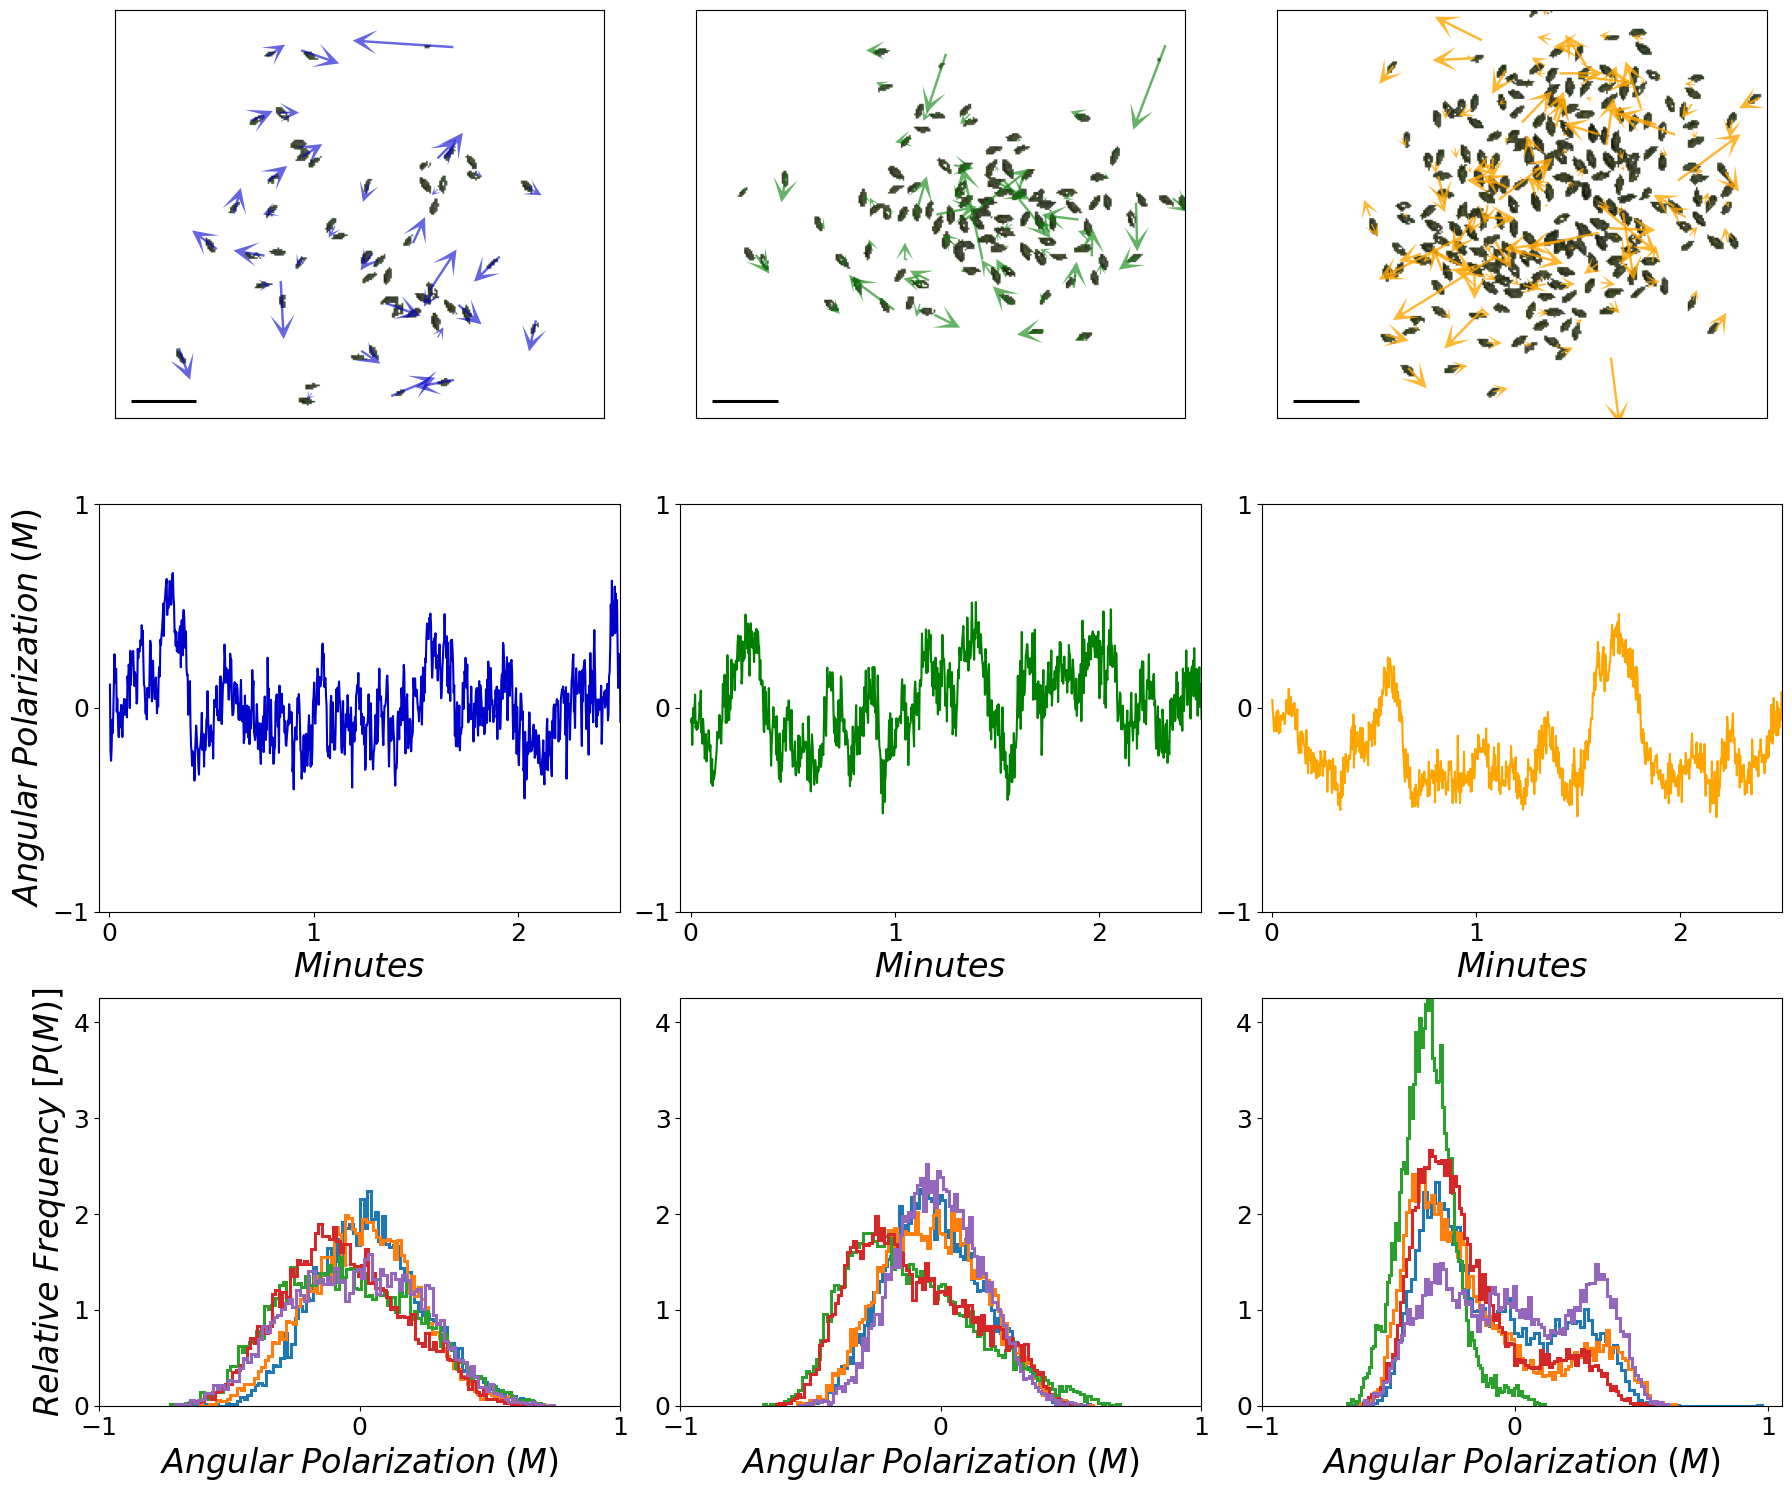

In [6]:
# Figure 2 compact but safe
tick_label_font_size = 18
axis_label_font_size = 24
f = plt.figure(figsize=[18,15], facecolor='white')

# Quiver plots
quivers = [(800, df_50D_omega, vid_50D, 'mediumblue', [600,900],[450,700],460,610,650),
           (2050, df_100D_omega, vid_100D, 'green', [750,1050],[550,800],560,760,800),
           (800, df_200D_omega, vid_200D, 'orange', [750,1050],[550,800],560,760,800)]
for idx,(i,df,vid,color,xlim_vals,ylim_vals,hline_y,hline_x0,hline_x1) in enumerate(quivers,1):
    plt.subplot(3,3,idx)
    image = vid.get_data(i+30)
    sel = df.index[df.frame==i]
    x = list(df.x[sel]); y = list(df.y[sel])
    vx = list(df.vx[sel]); vy = list(df.vy[sel])
    image[image>100] = 255
    image[image[:,:,1]>95] = 255
    plt.quiver(x,y,vx,vy,pivot='middle', headwidth=10, headlength=10, color=color,
               width=0.005, alpha=0.6 if color!='orange' else 0.8)
    plt.imshow(image)
    plt.xlim(xlim_vals); plt.ylim(ylim_vals)
    plt.xticks([]); plt.yticks([])
    plt.hlines(hline_y,hline_x0,hline_x1,'k',linewidth=2.2)

# Time series plots (exactly one trial each)
for idx,(sz,color) in enumerate(zip(['50','100','200'], ['mediumblue','g','orange']),4):
    plt.subplot(3,3,idx)
    plotting_range = np.arange(0,len(cirOP[sz]['A']),5)
    plt.plot(np.arange(0,len(cirOP[sz]['A']))[plotting_range]*1/30/60,
             cirOP[sz]['A'][plotting_range], color=color, alpha=1)
    plt.xlabel(r'$Minutes$', fontsize=axis_label_font_size)
    if idx==4: plt.ylabel(r'$Angular\;Polarization\;(M)$', fontsize=axis_label_font_size)
    plt.xlim([-0.05,2.5]); plt.ylim([-1,1])
    plt.xticks(np.arange(0,2.5,1),fontsize=tick_label_font_size)
    plt.yticks(np.arange(-1,1.1,1),fontsize=tick_label_font_size)

# Histograms (exactly same order and alpha as original)
hist_trials = ['A','B','C','D','E']
for idx,sz in enumerate(['50','100','200'],7):
    plt.subplot(3,3,idx)
    for tr in hist_trials:
        plt.hist(cirOP[sz][tr],100,density=True,histtype='step',linewidth=2.2)
    if idx==7: plt.ylabel(r'$Relative\;Frequency\;[P(M)]$', fontsize=axis_label_font_size)
    plt.xlabel(r'$Angular\;Polarization\;(M)$', fontsize=axis_label_font_size)
    plt.xticks(np.arange(-1,1.1,1), fontsize=tick_label_font_size)
    plt.ylim([0,4.25]); plt.yticks(np.arange(0,4.1,1), fontsize=tick_label_font_size)

plt.tight_layout(pad=1)
plt.savefig('../figures/panel_data.png',dpi=300)
plt.show()


In [7]:
# Pooling trials for each group size
pooledData = {'50':[],'100':[],'200':[]}

for i in tqdm(range(len(size))):
    for j in tqdm(range(len(trial))):
        f = open(file+'cirOP'+size[i] + trial[j],'rb')
        pooledData[size[i]].append(pickle.load(f))
        # data[np.isnan(data)] = 0
    pooledData[size[i]] = pooledData[size[i]][0].flatten()
    pooledData[size[i]][np.isnan(pooledData[size[i]])] = 0

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4043.87it/s]

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 2935.13it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 149.43it/s]


## Calculating drift and diffusion for pooled trials

This cell computes the deterministic (drift) and stochastic (diffusion) terms for each group size (`50`, `100`, `200`) using the pooled angular polarization data from all trials. The function `drift_diffusion` from `dataFunctions.py` returns:

- `pooledDrift`: estimated drift \(F(M)\)  
- `pooledDiffusion`: estimated diffusion \(G^2(M)\)  
- `pooledSEDrift`: standard error of drift  
- `pooledSEDiffusion`: standard error of diffusion  
- `op`: array of angular polarization values \(M\)


In [8]:
# Initialize dictionaries to store drift, diffusion, and standard errors
pooledDrift      = {s: [] for s in size}
pooledDiffusion  = {s: [] for s in size}
pooledSEDrift    = {s: [] for s in size}
pooledSEDiffusion= {s: [] for s in size}

# Compute drift, diffusion, and their standard errors for each group size
for s in tqdm(size, desc="Calculating drift & diffusion"):
    (pooledDrift[s], 
     pooledDiffusion[s], 
     pooledSEDrift[s], 
     pooledSEDiffusion[s], 
     op) = dF.drift_diffusion(pooledData[s], 1, 0.03, 0.01)


Calculating drift & diffusion: 100%|██████████████| 3/3 [00:00<00:00, 13.47it/s]


## Fitting drift and diffusion functions

This cell fits analytical functions to the estimated drift and diffusion terms:

- **Diffusion**: \(G^2(M) = a - b M^2\)  
- **Drift**: \(F(M) = a + b M + c M^2 + d M^3\)  

Steps:

1. Set a threshold for diffusion values beyond which data are ignored.
2. Fit the diffusion data (`pooledDiffusion`) to `func_diff` using `curve_fit`.
3. Assign precomputed drift parameters (`drift_popt`) for each group size from previous analysis (`pyDaddy`).
4. Evaluate the drift and diffusion functions over the `op` range to obtain fitted curves (`drift_y`, `diff_y`).


In [9]:
from scipy.optimize import curve_fit

# --- Functional forms ---
def func_diff(x, a, b):
    return a - b * x**2

def func_drift(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3

# --- Thresholds ---
diffusion_threshold = np.array([0.45, 0.30, 0.15])

# --- Allocate dictionaries ---
diff_popt  = {s: None for s in size}
diff_pcov  = {s: None for s in size}
drift_popt = {s: None for s in size}
diff_y     = {s: None for s in size}
drift_y    = {s: None for s in size}

# x-grid (preserved)
diff_x  = op.copy()
drift_x = op.copy()

# --- Fit diffusion ---
for i, s in enumerate(tqdm(size, desc="Fitting diffusion")):

    # Apply threshold
    pooledDiffusion[s][pooledDiffusion[s] > diffusion_threshold[i]] = np.nan

    # Clean values
    valid = ~np.isnan(pooledDiffusion[s])
    x_val = diff_x[valid]
    y_val = pooledDiffusion[s][valid]

    # Fit diffusion curve
    diff_popt[s], diff_pcov[s] = curve_fit(func_diff, x_val, y_val)

    # Evaluate fitted function
    diff_y[s] = func_diff(diff_x, *diff_popt[s])

# --- Drift parameters from pyDaddy ---
drift_popt['50']  = [0,     -2.155, 1.743,  -2.534]
drift_popt['100'] = [-0.078, -1.887, 0.635, -7.574]
drift_popt['200'] = [-0.059,  1.868, -0.251, -22.21]

# --- Evaluate drift curves ---
for s in tqdm(size, desc="Computing drift curves"):
    drift_y[s] = func_drift(drift_x, *drift_popt[s])


Computing drift curves: 100%|██████████████████| 3/3 [00:00<00:00, 11066.77it/s]


In [10]:
# Define probability distributions for each group size
PsM = {'50': [], '100': [], '200': []}
PsM_add = {'50': [], '100': [], '200': []}
x = op

# N = 50
PsM['50'] = (2.4e-5 * (1.16 - x)**20.86 * (1.16 + x)**44.68 * np.exp(14.88*x**2 - 20.46*x)) / (0.23 - 0.17*x**2)
PsM_add['50'] = 0.41 * 4.34 * np.exp(2 * (-2.75*x**4 + 2.52*x**3 - 4.67*x**2))

# N = 100
PsM['100'] = (1.1e-137 * (1.64 - x)**303.44 * (1.64 + x)**331.88 * np.exp(107.14*x**2 - 18*x)) / (0.18 - 0.07*x**2)
PsM_add['100'] = 0.37 * 5.26 * np.exp(2 * (-9.8*x**4 + 1.10*x**3 - 4.94*x**2 - 0.36*x))

# N = 200
PsM['200'] = (1.6e-119 * (1.3 - x)**522.56 * (1.3 + x)**512.12 * np.exp(316*x**2 + 7.14*x)) / (0.12 - 0.07*x**2)
PsM_add['200'] = 0.09 * 8.33 * np.exp(2 * (-46.27*x**4 - 0.69*x**3 + 7.75*x**2 - 0.41*x))


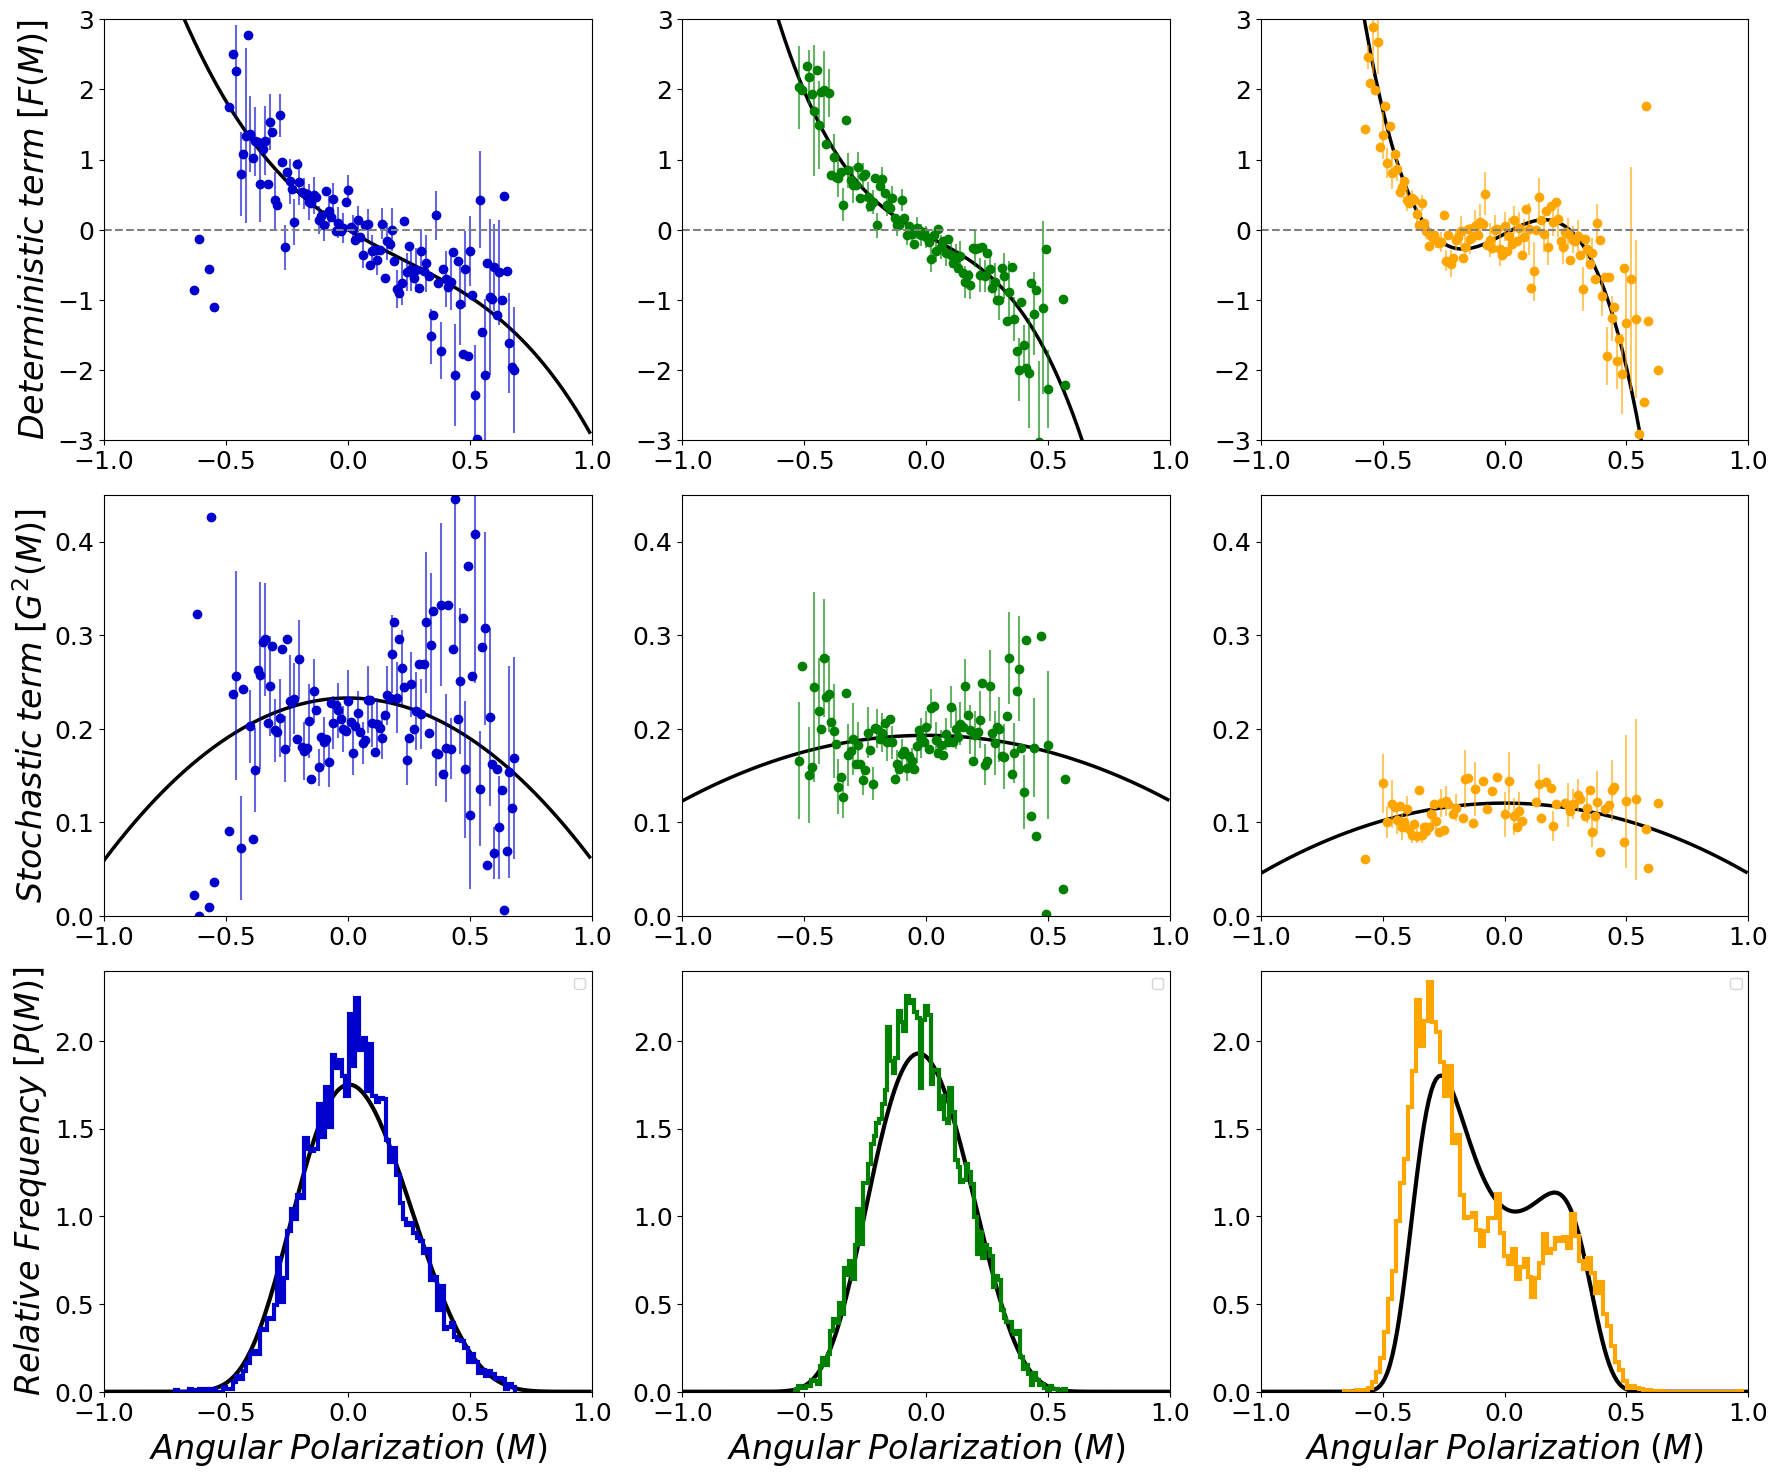

In [11]:
tick_label_font_size = 18
axis_label_font_size = 24
alpha = 0.6
col = ['mediumblue','g','orange']

plt.rc('xtick', labelsize=tick_label_font_size)
plt.rc('ytick', labelsize=tick_label_font_size)

fig, ax = plt.subplots(3, 3, figsize=[18, 15])

for i, s in enumerate(size):
    # --- Drift ---
    ax[0, i].plot(drift_x, drift_y[s], c='k', linewidth=2.5)
    ax[0, i].plot(drift_x, pooledDrift[s], 'o', c=col[i])
    ax[0, i].errorbar(drift_x, pooledDrift[s], pooledSEDrift[s],
                      linestyle='None', color=col[i], alpha=alpha, errorevery=2)
    ax[0, i].set_xlim([-1, 1])
    ax[0, i].set_ylim([-3, 3])
    ax[0, i].set_yticks(np.arange(-3, 3.1, 1))
    ax[0, i].hlines(0, -1, 1, colors='grey', linestyle='dashed')
    if i == 0:
        ax[0, i].set_ylabel(r'$Deterministic\;term\;[F(M)]$', fontsize=axis_label_font_size)

    # --- Diffusion ---
    ax[1, i].plot(diff_x, diff_y[s], c='k', linewidth=2.5)
    ax[1, i].plot(diff_x, pooledDiffusion[s], 'o', c=col[i])
    ax[1, i].errorbar(diff_x, pooledDiffusion[s], pooledSEDiffusion[s],
                      linestyle='None', color=col[i], alpha=alpha, errorevery=2)
    ax[1, i].set_xlim([-1, 1])
    ax[1, i].set_ylim([0, 0.45])
    if i == 0:
        ax[1, i].set_ylabel(r'$Stochastic\;term\;[G^2(M)]$', fontsize=axis_label_font_size)

    # --- PDF / Histogram ---
    ax[2, i].plot(x, PsM[s], linewidth=3, color='k')
    # ax[2, i].plot(x, PsM_add[s], linewidth=3, color=col[i], label="Additive Noise")
    ax[2, i].hist(pooledData[s], bins=100, density=True, histtype='step', linewidth=3, color=col[i])
    ax[2, i].set_xlabel(r'$Angular\;Polarization\;(M)$', fontsize=axis_label_font_size)
    if i == 0:
        ax[2, i].set_ylabel(r'$Relative\;Frequency\;[P(M)]$', fontsize=axis_label_font_size)
    ax[2, i].set_xlim([-1, 1])
    ax[2, i].set_ylim([0, 2.4])
    ax[2, i].set_yticks(np.arange(0, 2.1, 0.5))
    ax[2, i].legend(loc='best')

plt.tight_layout(pad=1.5)
plt.savefig('../figures/drift_diffusion_fits_reconstruction.png', dpi=300)
plt.show()


## Calculating R^2

In [12]:
drift_threshold = np.array([3,3,3])
for i in range(1,len(size)):
    pooledDrift[size[i]][pooledDrift[size[i]] > drift_threshold[i]] = np.nan
    if i == 0:
        pooledDrift[size[i]][pooledDrift[size[i]] < -drift_threshold[i]] = np.nan
    print('R^2 for Drift N = '+str(size[i])+': '+str(1 - (np.nanmean((drift_y[size[i]] - pooledDrift[size[i]])**2) / np.nanvar(pooledDrift[size[i]]))))

R^2 for Drift N = 100: 0.8119556592422
R^2 for Drift N = 200: 0.8046079820107377


In [13]:
i = 0
drift_threshold = np.array([3,3,3])
pooledDrift[size[i]][op > 0.6] = np.nan
pooledDrift[size[i]][op < -0.6] = np.nan
print('R^2 for Drift N = '+str(size[i])+': '+str(1 - (np.nanmean((drift_y[size[i]] - pooledDrift[size[i]])**2) / np.nanvar(pooledDrift[size[i]]))))

R^2 for Drift N = 50: 0.601950928496275


## Figure 4 - Model analysis

In [15]:


# Load model-generated angular polarization data
f = open('../data/model_data/model_angular_pol_phase_diagram_N', 'rb')
avg_angular_pol = pickle.load(f)

# Group-size parameter values used in the model
param_y_list = [10, 25, 50, 100, 150, 200, 250, 300]
y_param = param_y_list


In [16]:

# # Load simulation videos for different group sizes
# filename = '../movies/simulation_N200L100.mp4'
# vid_sims200 = imageio.get_reader(filename, 'ffmpeg')

# filename = '../movies/simulation_N50L100.mp4'
# vid_sims50 = imageio.get_reader(filename, 'ffmpeg')

# filename = '../movies/simulation_N100L100.mp4'
# vid_sims100 = imageio.get_reader(filename, 'ffmpeg')


In [17]:
# Initialize containers for storing model-based drift and diffusion estimates
modelDrift = {}
modelDrift_raw = {}
modelDiffusion = {}
modelDiffusion_raw = {}
modelSEDrift = {}
modelSEDiffusion = {}

# Set up empty lists for each group size in param_y_list
for i in range(len(param_y_list)):
    N = param_y_list[i]  # group size
    modelDrift[N] = []
    modelDrift_raw[N] = []
    modelDiffusion[N] = []
    modelDiffusion_raw[N] = []
    modelSEDrift[N] = []
    modelSEDiffusion[N] = []


In [18]:

for i in tqdm(range(len(param_y_list))):
    N = param_y_list[i]  # group size

    # Compute drift, diffusion, and associated standard errors
    (
        modelDrift[N],
        modelDiffusion[N],
        modelSEDrift[N],
        modelSEDiffusion[N],
        op
    ) = dF.drift_diffusion(
        avg_angular_pol[i][0],   # model angular polarization trajectory
        1,                       # dt = 1
        0.1,                     # bin size
        0.04                     # smoothing window
    )


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.46it/s]


## Fit Diffusion Curves for Model Data

In [19]:
from scipy.optimize import curve_fit
import numpy as np

# --- Define functional forms ---
def func_diff(x, a, b):
    return a - b * x**2

def func_drift(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3

# --- Initialize dictionaries ---
modelDiff_popT = {N: [] for N in param_y_list}
modelDiff_pCov = {N: [] for N in param_y_list}
model_diff_y   = {N: [] for N in param_y_list}
# --- x-axis for diffusion ---
model_diff_x = op.copy()


# --- Fit diffusion for each group size ---
for N in param_y_list:
    # Select valid (non-NaN) entries
    ind = ~np.isnan(modelDiffusion[N])
    x_val = op[ind]
    y_val = modelDiffusion[N][ind]

    # Fit diffusion curve
    modelDiff_popT[N], modelDiff_pCov[N] = curve_fit(func_diff, x_val, y_val)

    # Evaluate fitted function
    model_diff_y[N] = func_diff(op, *modelDiff_popT[N])


In [20]:


# --- Allocate arrays for each group size ---
drift_y_sim = [np.ndarray(op.shape[0]) for _ in range(len(param_y_list))]
diff_y_sim  = [np.ndarray(op.shape[0]) for _ in range(len(param_y_list))]

x = op

# --- PyDaddy drift and diffusion fits ---
drift_y_sim[0] = -0.124 * x + (-0.018) * x**3
diff_y_sim[0]  = 0.031 + (-0.008) * x**2

drift_y_sim[1] = -0.053 * x
diff_y_sim[1]  = 0.010 * np.ones(op.shape[0])

drift_y_sim[2] = -0.017 * x
diff_y_sim[2]  = 0.005 + (-0.004) * x**2

drift_y_sim[3] = -0.010 * x**3
diff_y_sim[3]  = 0.002 + (-0.002) * x**2

drift_y_sim[4] = 0.006 * x + (-0.019) * x**3
diff_y_sim[4]  = 0.002 + (-0.002) * x**2

drift_y_sim[5] = 0.010 * x + (-0.025) * x**3
diff_y_sim[5]  = 0.001 + (-0.002) * x**2

drift_y_sim[6] = 0.008 * x + (-0.019) * x**3
diff_y_sim[6]  = 0.001 + (-0.001) * x**2

drift_y_sim[7] = 0.006 * x + (-0.016) * x**3
diff_y_sim[7]  = 0.001 + (-0.001) * x**2


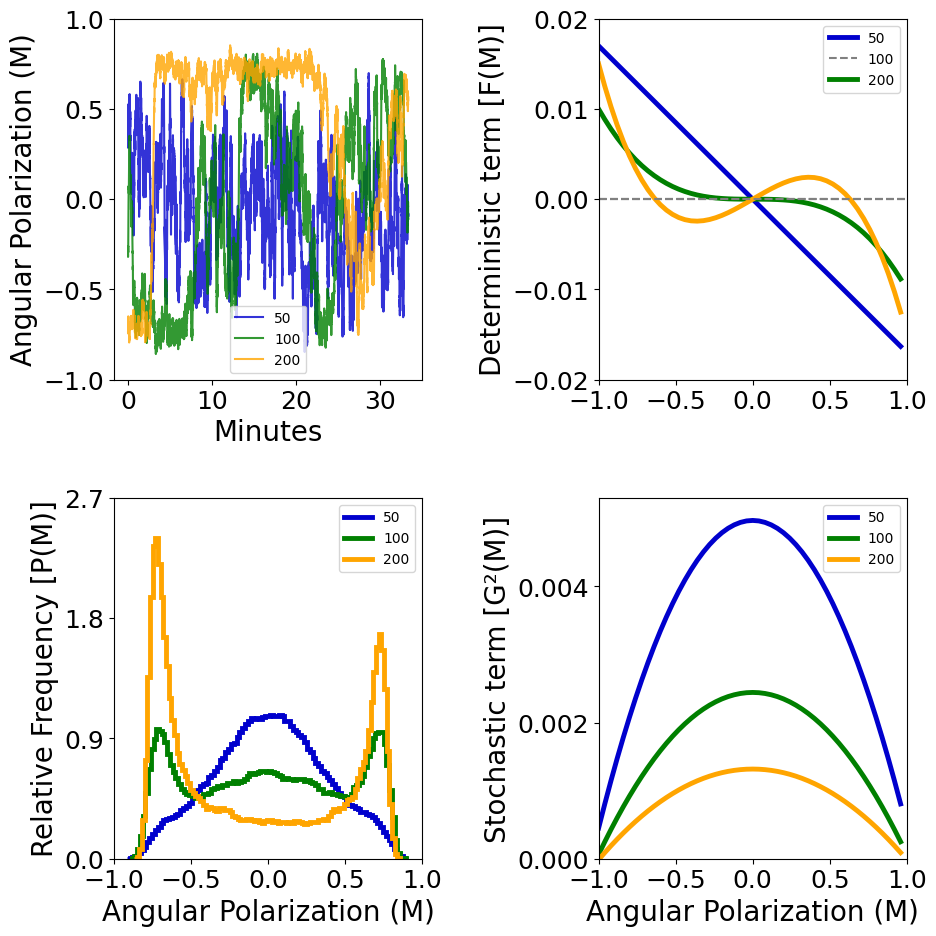

In [21]:
from matplotlib.lines import Line2D

tick_label_font_size = 18
axis_label_font_size = 20
alpha = 0.8
col = ['mediumblue', 'g', 'orange']

plt.rc('xtick', labelsize=tick_label_font_size)
plt.rc('ytick', labelsize=tick_label_font_size)

# --- x-axis for diffusion ---
model_diff_x = op.copy()

# --- Compute mean angular polarization ---
mean_angular_pol = np.zeros((len(avg_angular_pol), len(avg_angular_pol[0])))
for i in range(len(avg_angular_pol)):
    for j in range(len(avg_angular_pol[0])):
        mean_angular_pol[i, j] = np.mean(abs(avg_angular_pol[i][j]))

# --- Set up 2x2 figure ---
f, ax = plt.subplots(2, 2, figsize=(10, 10), facecolor='white')

labels = ['50', '100', '200']
handles = []

# --- Time series and histogram ---
j = 0
for i in [2, 3, 5]:
    # Time series
    ax[0, 0].plot(np.arange(len(avg_angular_pol[i][0][30000:50000])) * 0.1 / 60,
                  avg_angular_pol[i][0][30000:50000], color=col[j], alpha=alpha)
    # Histogram
    ax[1, 0].hist(avg_angular_pol[i][0], 100, density=True, histtype='step',
                   linewidth=3.5, color=col[j])
    # Custom handle for legend
    handles.append(Line2D([0], [0], color=col[j], lw=3.5))
    j += 1

# Axis labels and limits for time series
ax[0, 0].set_xlabel('Minutes', fontsize=axis_label_font_size)
ax[0, 0].set_ylabel('Angular Polarization (M)', fontsize=axis_label_font_size)
ax[0, 0].set_ylim([-1, 1])
ax[0, 0].set_yticks(np.arange(-1, 1.1, 0.5))
ax[0, 0].legend(labels, loc='best')

# Axis labels and limits for histogram
ax[1, 0].set_xlim([-1, 1])
ax[1, 0].set_ylim([0, 2.7])
ax[1, 0].set_yticks(np.arange(0, 2.8, 0.9))
ax[1, 0].set_xlabel('Angular Polarization (M)', fontsize=axis_label_font_size)
ax[1, 0].set_ylabel('Relative Frequency [P(M)]', fontsize=axis_label_font_size)
ax[1, 0].legend(handles, labels)

# --- Drift and diffusion fits ---
j = 0
for i in [2, 3, 5]:
    # Drift
    ax[0, 1].plot(op, drift_y_sim[i], linewidth=3.5, c=col[j])
    ax[0, 1].set_xlim([-1, 1])
    ax[0, 1].set_ylim([-0.02, 0.02])
    ax[0, 1].set_yticks(np.arange(-0.02, 0.021, 0.01))
    ax[0, 1].set_ylabel('Deterministic term [F(M)]', fontsize=axis_label_font_size)
    ax[0, 1].hlines(0, -1, 1, colors='grey', linestyle='dashed')

    # Diffusion
    ax[1, 1].plot(model_diff_x, model_diff_y[param_y_list[i]], linewidth=3.5, c=col[j])
    ax[1, 1].set_xlim([-1, 1])
    ax[1, 1].set_ylim([0, 0.0053])
    ax[1, 1].set_yticks(np.arange(0, 0.0051, 0.002))
    ax[1, 1].set_ylabel('Stochastic term [G²(M)]', fontsize=axis_label_font_size)
    ax[1, 1].set_xlabel('Angular Polarization (M)', fontsize=axis_label_font_size)
    j += 1

ax[0, 1].legend(labels, loc='best')
ax[1, 1].legend(labels, loc='best')

plt.tight_layout(pad=3.0)
plt.savefig('../figures/model_time_series_hist_drift_diffusion_fits.png',
            dpi=300, bbox_inches='tight')
plt.show()


### Figure 5: Autocorrelation and Noise Analysis of Polarization Dynamics

**Overview:**  
This figure presents a comprehensive analysis of temporal correlations and noise in both experimental data and model-simulated polarization time series for groups of size 50, 100, and 200 agents.

---

**Row 1: Autocorrelation of Experimental Data (ACF Data)**  
- Shows the autocorrelation function (ACF) of the pooled polarization time series for each group size.  
- **Blue Line:** ACF of the experimental data.  
- **Grey Dashed Lines:** ±1 standard deviation of null ACF, computed from random data to represent the baseline expectation.  
- **X-axis:** Lag in seconds.  
- **Y-axis:** Autocorrelation magnitude, showing how strongly the system is correlated with its past states.  
- **Purpose:** Reveals temporal persistence in collective polarization dynamics.

**Row 2: Autocorrelation of Noise (ACF Noise)**  
- Displays the ACF of the noise extracted from the polarization signal. Noise is computed as the deviation of each data point from the local mean.  
- **Blue Line:** ACF of the noise.  
- **Grey Dashed Lines:** ±1 standard deviation of null ACF from random noise.  
- **X-axis:** Lag in seconds.  
- **Y-axis:** Autocorrelation of the noise component.  
- **Purpose:** Indicates whether short-term fluctuations are correlated over time or are effectively random.

**Row 3: Cumulative Distribution of Noise**  
- Shows the cumulative distribution function (CDF) of the noise differences (between consecutive time points around zero crossings).  
- **Blue Line:** Empirical CDF from data.  
- **Red Line:** CDF of a fitted normal distribution.  
- **X-axis:** Noise magnitude (η).  
- **Y-axis:** Cumulative probability, from 0 to 1.  
- **Purpose:** Assesses whether the noise distribution approximates Gaussian statistics and quantifies deviation from normality.

**Row 4: Autocorrelation of Model-Simulated Time Series (ACF Model)**  
- Depicts the ACF of polarization time series simulated using drift and diffusion parameters inferred from the data.  
- **Blue Line:** ACF of model-simulated polarization.  
- **Grey Dashed Lines:** ±1 standard deviation of null ACF from random time series.  
- **X-axis:** Lag in seconds.  
- **Y-axis:** Autocorrelation magnitude.  
- **Purpose:** Validates whether the model reproduces the temporal structure and persistence observed in experimental data.

---

**Legend for All Panels:**  
- Group sizes: 50, 100, 200 agents.  
- Blue: Data or model ACF / noise CDF.  
- Grey Dashed: Null baseline.  
- Red (Row 3 only): Fitted normal CDF.


In [22]:
from numba import vectorize, float64

@vectorize([float64(float64, float64, float64)], target='cuda')
def acf(a, b, mu):
    """
    Compute the auto-covariance term for two values given the mean.

    Parameters
    ----------
    a : float
        First value.
    b : float
        Second value.
    mu : float
        Mean of the series.

    Returns
    -------
    float
        Auto-covariance (a-mu)*(b-mu) or NaN if b is zero.
    """
    if b == 0:
        return float('nan')
    return (a - mu) * (b - mu)


In [23]:

def calc_acf(x, lag):
    """
    Calculate the normalized autocorrelation function up to a given lag.

    Parameters
    ----------
    x : np.ndarray
        Input time series.
    lag : int
        Maximum lag to compute autocorrelation for.

    Returns
    -------
    np.ndarray
        Normalized autocorrelation values for lags 0 to lag-1.
    """
    ac = []

    # Lag 0 (autocovariance with itself)
    mu = np.nanmean(x)
    ac.append(np.nanmean(acf(x, x, mu)))

    # Compute autocovariance for lags 1 to lag-1
    for l in range(1, lag):
        y = np.zeros(len(x), dtype=np.float64)
        y[0:-l] = x[l:]
        ac.append(np.nanmean(acf(x, y, mu)))

    # Normalize by variance
    ac = np.array(ac) / np.nanvar(x)
    return ac

# Example usage:
# lag_vec50 = range(lag)
# lag_vec100 = range(lag)
# lag_vec200 = range(lag)


In [24]:
def compute_acf_for_pooled(pooled_data, lag=2000, seed=None):
    """
    Compute autocorrelations and null autocorrelations for all group sizes.

    Parameters
    ----------
    pooled_data : dict
        Dictionary with keys like '50', '100', '200' containing merged data arrays.
    lag : int
        Maximum lag for autocorrelation (default 2000).
    seed : int, optional
        Random seed for reproducibility of null data.

    Returns
    -------
    acf_dict : dict
        Dictionary of autocorrelations for each group size.
    acf_null_dict : dict
        Dictionary of null autocorrelations for each group size.
    """
    acf_dict = {}
    acf_null_dict = {}

    for key, data in pooled_data.items():
        op_data = np.asarray(data).flatten()  # ensure 1D
        op_data[-1] = 0
        op_data[np.isnan(op_data)] = 0

        acf_dict[key] = calc_acf(op_data, lag)

        if seed is not None:
            np.random.seed(seed)
        null_data = np.random.rand(len(op_data))
        acf_null_dict[key] = calc_acf(null_data, lag)

    return acf_dict, acf_null_dict

# Usage:
acf_merged, acf_null = compute_acf_for_pooled(pooledData, lag=2000)


In [25]:
def noise_correlation_pooled(pooled_data, lag_noise=100, lag_null=2000):
    """
    Compute noise correlation, its autocorrelation, and immediate differences
    for each group size in pooled_data.

    Parameters
    ----------
    pooled_data : dict
        Keys are group sizes (as strings), values are 1D arrays of pooled time series.
    lag_noise : int
        Number of lags for computing noise autocorrelation.
    lag_null : int
        Number of lags for computing null autocorrelation.

    Returns
    -------
    acf_noise_dict : dict
        Autocorrelation of the computed noise for each group size.
    acf_noise_null_dict : dict
        Autocorrelation of random noise for each group size.
    noise_diff_dict : dict
        Differences of op_data around zero crossings for each group size.
    """
    acf_noise_dict = {}
    acf_noise_null_dict = {}
    noise_diff_dict = {}

    for key, data in pooled_data.items():
        op_data = np.asarray(data).flatten()  # ensure 1D

        # --- Noise signal by local deviation ---
        noise_corr = np.zeros(len(op_data))
        for k in range(10, len(op_data)-10):
            noise_corr[k] = op_data[k] - np.mean(op_data[k-10:k+10])

        # Autocorrelation of noise
        acf_noise_dict[key] = calc_acf(noise_corr, lag_noise)

        # Differences near zero
        op_data[-1] = 1
        op_data[-2] = 1
        zero_inds = np.where((op_data >= -0.01) & (op_data <= 0.01))[0]
        noise_diff_dict[key] = np.array([op_data[i+1] - op_data[i] for i in zero_inds if i+1 < len(op_data)])

        # Null autocorrelation
        null = np.random.rand(len(op_data))
        acf_noise_null_dict[key] = calc_acf(null, lag_null)

    return acf_noise_null_dict, acf_noise_dict, noise_diff_dict

# Example usage with pooledData:
acf_noise_null, acf_noise, noise_diff = noise_correlation_pooled(pooledData)


In [26]:
'''Simulating Angular Polarization Time Series using Drift and Diffusion

This code simulates time series of angular polarization `M` using the drift and diffusion
estimated from empirical data. The simulation follows a stochastic differential equation:
 
\[
x_{t+1} = x_t + F(x_t)\Delta t + \sqrt{G^2(x_t)\Delta t}\,\eta
\]
 
where `F(x)` is the drift function, `G^2(x)` is the diffusion function, `Δt` is the time step,
and `η` is standard Gaussian noise.'''


# --- Parameters ---
sizes = ['50','100','200']  # group sizes
iterations = 50000           # number of time steps
dt = 0.01                    # time step
pol = {s: [] for s in sizes} # store simulated polarization

# --- Drift parameters from PyDaddy ---
drift_popt = {
    '50': [0, -2.155, 1.743, -2.534],
    '100': [-0.078, -1.887, 0.635, -7.574],
    '200': [-0.059, 1.868, -0.251, -22.21]
}

# --- Diffusion parameters from curve fitting ---
diff_popt = {
    '50': [0.21174252, -0.1574377],
    '100': [0.19304348, 0.07007934],
    '200': [0.12062925, 0.0751737]
}

# --- Simulation loop ---
for m, size in enumerate(sizes):
    x = np.zeros(iterations, dtype=np.float32)
    x[0] = np.random.rand()*2 - 1  # initial polarization in [-1,1]
    i = 0

    while i < (iterations-1):
        eta = np.random.normal()  # Gaussian noise

        # --- Compute drift F(x) ---
        drift_sim = (drift_popt[size][0] +
                     drift_popt[size][1]*x[i] +
                     drift_popt[size][2]*x[i]**2 +
                     drift_popt[size][3]*x[i]**3)

        # --- Compute diffusion G^2(x) ---
        diffusion_sim_sq = diff_popt[size][0] - diff_popt[size][1]*x[i]**2

        # Skip step if diffusion becomes negative
        if diffusion_sim_sq < 0:
            i -= 1
            continue

        # --- Update polarization ---
        x[i+1] = x[i] + drift_sim*dt + np.sqrt(diffusion_sim_sq)*np.sqrt(dt)*eta
        pol[size].append(x[i])
        i += 1

# Convert lists to arrays if needed
for size in sizes:
    pol[size] = np.array(pol[size])


In [27]:
from statsmodels.tsa.stattools import acf

# Parameters
lag_model_50_100 = 1000
lag_model_200 = 1000
dt_model = 0.01  # time step for converting lags to seconds

# Group sizes
group_sizes = ['50', '100', '200']

# Dictionaries to store results
acf_model = {}
acf_null_model = {}
time_lags = {}

for g in group_sizes:
    x = np.array(pol[g])
    null = np.random.rand(len(x))

    lag_max = lag_model_50_100 if g != '200' else lag_model_200

    acf_model[g] = acf(x, nlags=lag_max)
    acf_null_model[g] = acf(null, nlags=lag_max)
    time_lags[g] = np.arange(lag_max + 1) * dt_model  # convert to seconds


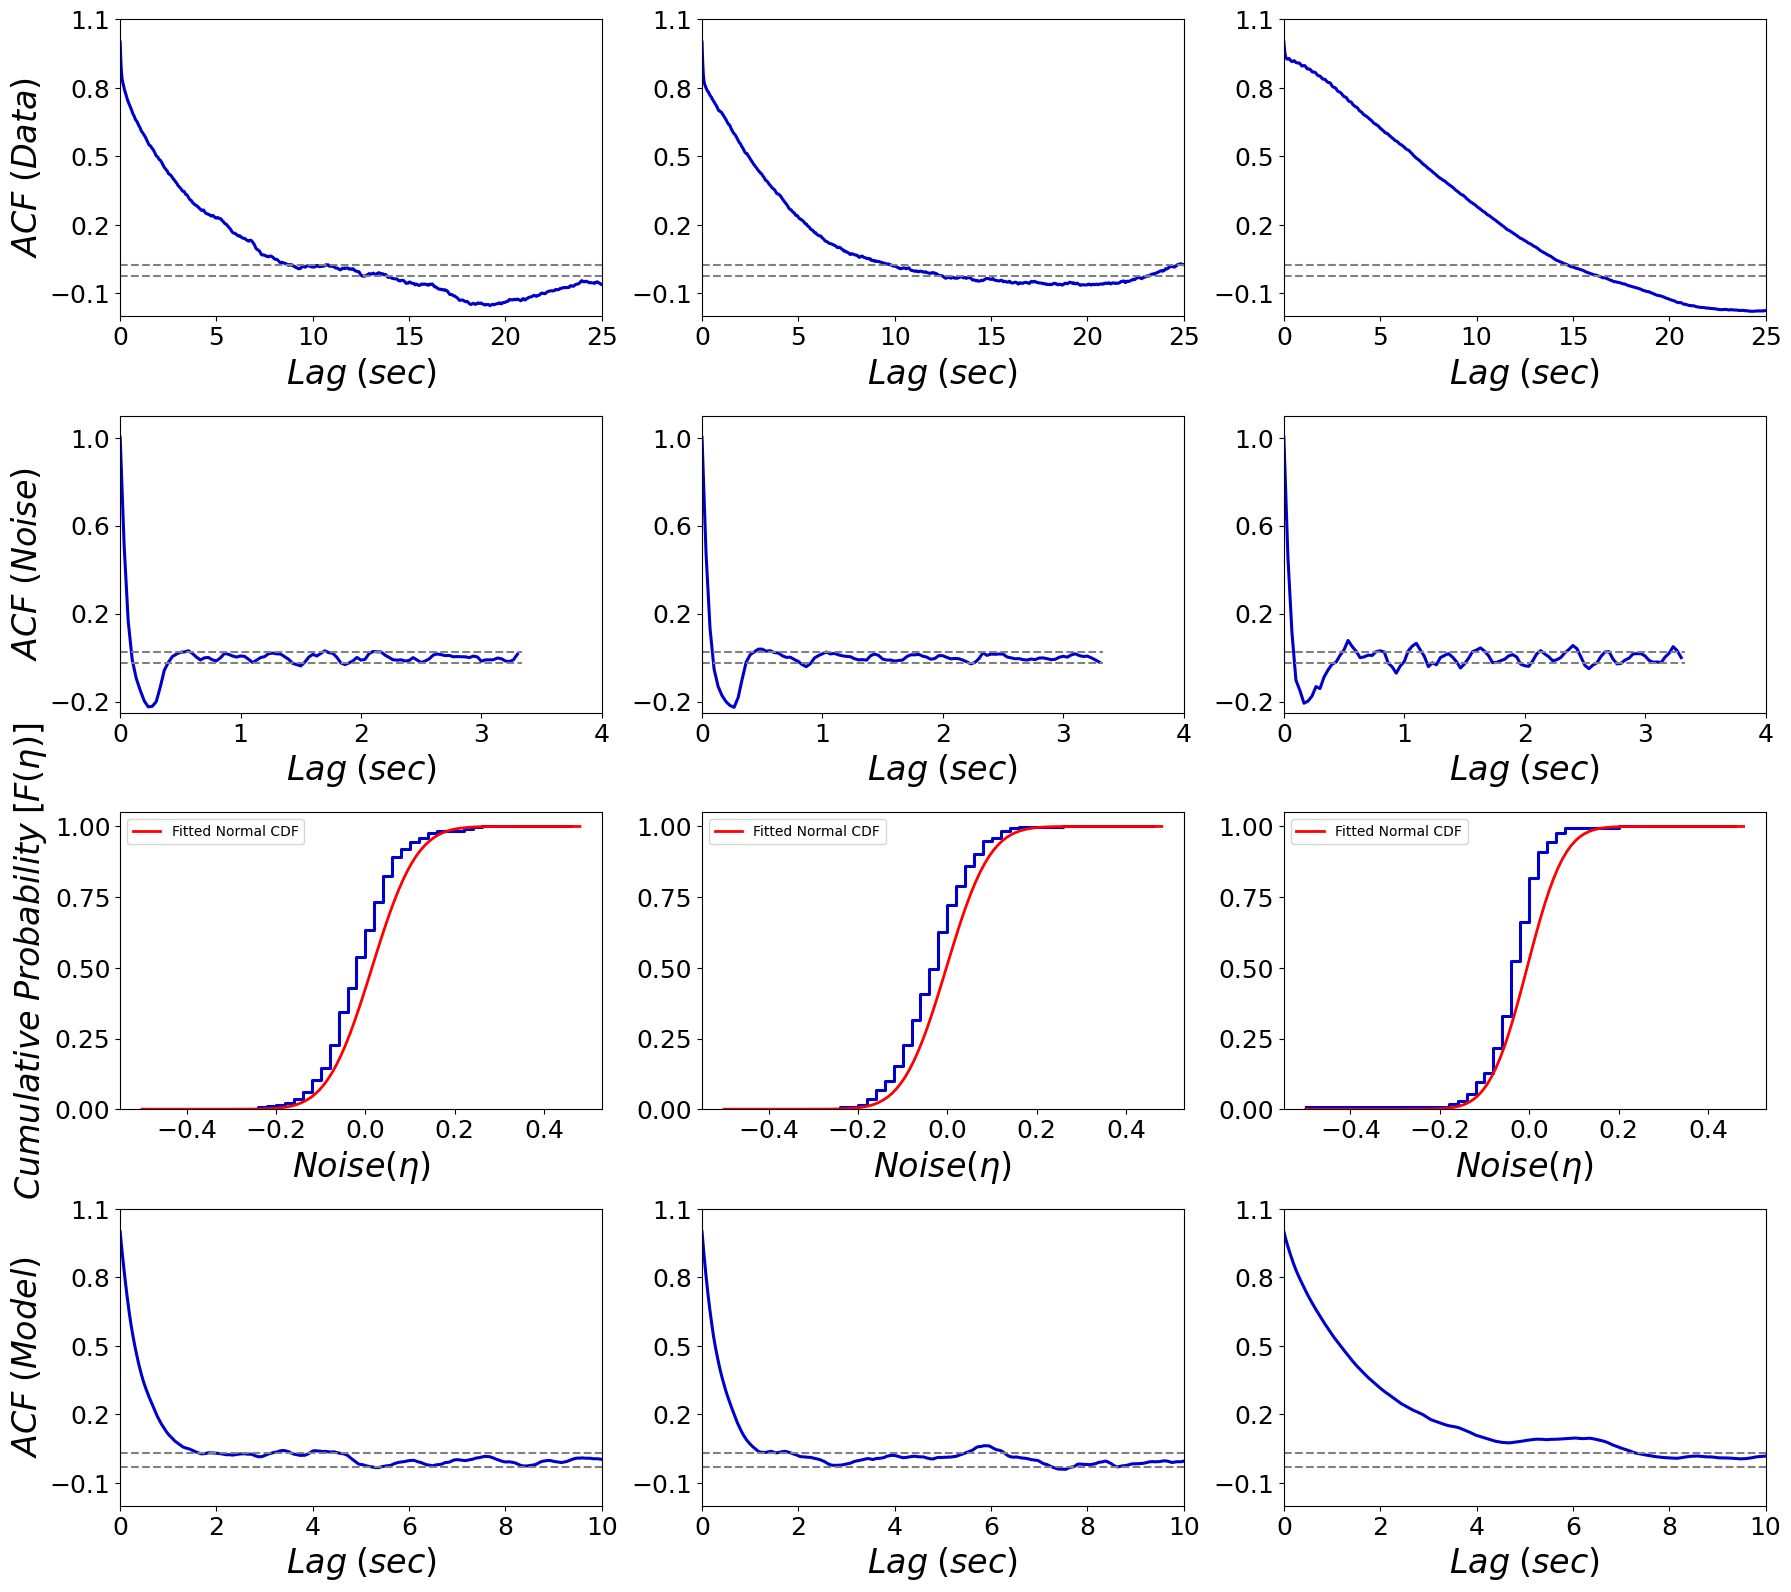

In [29]:
from scipy.stats import norm, kstest

# Settings
tick_label_font_size = 18
axis_label_font_size = 24
alpha = 0.6
group_sizes = ['50', '100', '200']
colors = ['mediumblue', 'g', 'orange']

plt.rc('xtick', labelsize=tick_label_font_size)
plt.rc('ytick', labelsize=tick_label_font_size)

# Prepare figure
f, ax = plt.subplots(4, 3, figsize=[18, 16])

# ---- Panel 1: Data ACF ----
for i, g in enumerate(group_sizes):
    ax[0, i].plot(np.arange(0, len(acf_merged[g])) / 30, acf_merged[g], color='mediumblue', linewidth=2.2)
    ax[0, i].hlines([np.std(acf_null[g]), -np.std(acf_null[g])], 0, len(acf_merged[g]) / 30,
                     colors='grey', linewidth=1.5, linestyle='dashed')
    ax[0, i].set_xlim([0, 25])
    ax[0, i].set_ylim([-0.2, 1.1])
    ax[0, i].set_yticks(np.arange(-0.1, 1.1, 0.3))
    ax[0, i].set_xlabel(r'$Lag\;(sec)$', fontsize=axis_label_font_size)
    if i == 0:
        ax[0, i].set_ylabel(r'$ACF\;(Data)$', fontsize=axis_label_font_size)

# ---- Panel 2: Noise ACF ----
for i, g in enumerate(group_sizes):
    ax[1, i].plot(np.arange(0, len(acf_noise[g])) / 30, acf_noise[g], color='mediumblue', linewidth=2.2)
    ax[1, i].hlines([np.std(acf_noise_null[g]), -np.std(acf_noise_null[g])], 0, len(acf_noise[g]) / 30,
                     colors='grey', linewidth=1.5, linestyle='dashed')
    ax[1, i].set_xlim([0, 4])
    ax[1, i].set_ylim([-0.25, 1.1])
    ax[1, i].set_yticks(np.arange(-0.2, 1.2, 0.4))
    ax[1, i].set_xlabel(r'$Lag\;(sec)$', fontsize=axis_label_font_size)
    if i == 0:
        ax[1, i].set_ylabel(r'$ACF\;(Noise)$', fontsize=axis_label_font_size)

# ---- Panel 3: Noise CDF vs Normal ----
bin_range = np.arange(-0.5, 0.5, 0.02)
for i, g in enumerate(group_sizes):
    # Histogram → CDF
    counts, bins = np.histogram(noise_diff[g], bins=bin_range, density=True)
    cdf_counts = np.cumsum(counts) * np.diff(bins)[0]
    ax[2, i].step(bins[:-1], cdf_counts, linewidth=2.2, color='mediumblue')

    # Fit Normal & plot CDF
    mu, std = norm.fit(noise_diff[g])
    D, p_value = kstest(noise_diff[g], 'norm', args=(mu, std))
    x = np.linspace(bins[0], bins[-1], 100)
    ax[2, i].plot(x, norm.cdf(x, mu, std), 'r', linewidth=2, label='Fitted Normal CDF')

    ax[2, i].set_xlabel(r'$Noise (\eta)$', fontsize=axis_label_font_size)
    ax[2, i].set_ylim([0, 1.05])
    if i == 0:
        ax[2, i].set_ylabel(r'$Cumulative\;Probability\;[F(\eta)]$', fontsize=axis_label_font_size)
    ax[2, i].legend()

# ---- Panel 4: Model ACF ----
group_sizes = ['50', '100', '200']

for i, g in enumerate(group_sizes):
    ax[3, i].plot(time_lags[g], acf_model[g], color='mediumblue', linewidth=2.2)
    ax[3, i].hlines(np.std(acf_null_model[g]), 0, time_lags[g][-1],
                    colors='grey', linewidth=1.5, linestyle='dashed')
    ax[3, i].hlines(-np.std(acf_null_model[g]), 0, time_lags[g][-1],
                    colors='grey', linewidth=1.5, linestyle='dashed')
    ax[3, i].set_xlim([0, time_lags[g][-1]])
    ax[3, i].set_ylim([-0.2, 1.1])
    ax[3, i].set_yticks(np.arange(-0.1, 1.1, 0.3))
    ax[3, i].set_xlabel(r'$Lag\;(sec)$', fontsize=axis_label_font_size)
    if i == 0:
        ax[3, i].set_ylabel(r'$ACF\;(Model)$', fontsize=axis_label_font_size)


plt.tight_layout(pad=1)
plt.savefig('../figures/stats_data.png', dpi=600, bbox_inches='tight')
plt.show()


### Figure 6: Mean Residence Times in Metastable States

This figure shows the **cumulative distribution (CCDF) of residence times** for transitions between two metastable states in the system, for three group sizes: `N = 50, 100, 200`.  

#### Panel Description
- **Top row (Experimental Data):**  
  CCDF \(P(T > \tau_f)\) of residence times from experimental time series. Circles indicate measured data points; dashed red lines show exponential fits \((\text{CCDF} \sim e^{-\lambda t})\) with slope and R² annotated.

- **Bottom row (Model Data):**  
  CCDF for simulated/model time series generated from fitted drift-diffusion dynamics. Circles indicate model data points; dashed red lines indicate corresponding exponential fits.

#### Axes
- **x-axis:** Residence time \(\tau_f\) (seconds) for transitions between the two metastable states.  
- **y-axis:** CCDF \(P(T > \tau_f)\), plotted on a **logarithmic scale**.  

#### Key Observations
- Residence times approximately follow an **exponential distribution**, in both experimental and model data.  
- Larger groups tend to show **longer mean residence times**, reflecting slower transitions between states.  
- The model reproduces the overall trend of the experimental CCDFs across all group sizes.


In [30]:

def compute_mean_transition_time(ts, state_A, state_B, epsilon, dt):
    """
    Compute residence times for transitions between two metastable states in a time series.

    Parameters
    ----------
    ts : array-like
        1D time series of system states over time.
    state_A : float
        Central value of the first metastable state (e.g., -0.3).
    state_B : float
        Central value of the second metastable state (e.g., +0.3).
    epsilon : float
        Tolerance around state values (i.e., state A is within [A-ε, A+ε]).
    dt : float
        Time step between consecutive time points in the series.

    Returns
    -------
    dict
        Dictionary containing:
        - "A_to_B_durations": list of durations spent in state A before transitioning to B
        - "B_to_A_durations": list of durations spent in state B before transitioning to A
        - "mean_A_to_B": mean duration of A→B transitions
        - "mean_B_to_A": mean duration of B→A transitions
    """

    ts = np.asarray(ts).flatten()  # ensure 1D array

    # Helper functions to check if value is within ε of the target state
    in_A = lambda x: abs(x - state_A) <= epsilon
    in_B = lambda x: abs(x - state_B) <= epsilon

    transitions_A_to_B = []
    transitions_B_to_A = []
    i = 0

    while i < len(ts):

        # -------- Detect A → B transition --------
        if in_A(ts[i]):
            start = i
            i += 1
            while i < len(ts) and not in_B(ts[i]):
                i += 1
            if i < len(ts):
                transitions_A_to_B.append((i - start) * dt)
            continue

        # -------- Detect B → A transition --------
        if in_B(ts[i]):
            start = i
            i += 1
            while i < len(ts) and not in_A(ts[i]):
                i += 1
            if i < len(ts):
                transitions_B_to_A.append((i - start) * dt)
            continue

        i += 1  # move forward if not in A or B

    mean_A_to_B = np.mean(transitions_A_to_B) if transitions_A_to_B else None
    mean_B_to_A = np.mean(transitions_B_to_A) if transitions_B_to_A else None

    return {
        "A_to_B_durations": transitions_A_to_B,
        "B_to_A_durations": transitions_B_to_A,
        "mean_A_to_B": mean_A_to_B,
        "mean_B_to_A": mean_B_to_A
    }


In [31]:
# Compute mean residence times for all group sizes
output_dict = {}
model_output_dict = {}

for key, data in pooledData.items():
    # Experimental data
    output_dict[key] = compute_mean_transition_time(data, 0.3, -0.3, 0.05, 1/30)

# Model data: assuming avg_angular_pol has model time series
# Example mapping: '50'->avg_angular_pol[2], '100'->avg_angular_pol[3], '200'->avg_angular_pol[5]
model_mapping = {'50': 2, '100': 3, '200': 5}
for key, idx in model_mapping.items():
    model_output_dict[key] = compute_mean_transition_time(avg_angular_pol[idx], 0.7, -0.7, 0.05, 1/10)


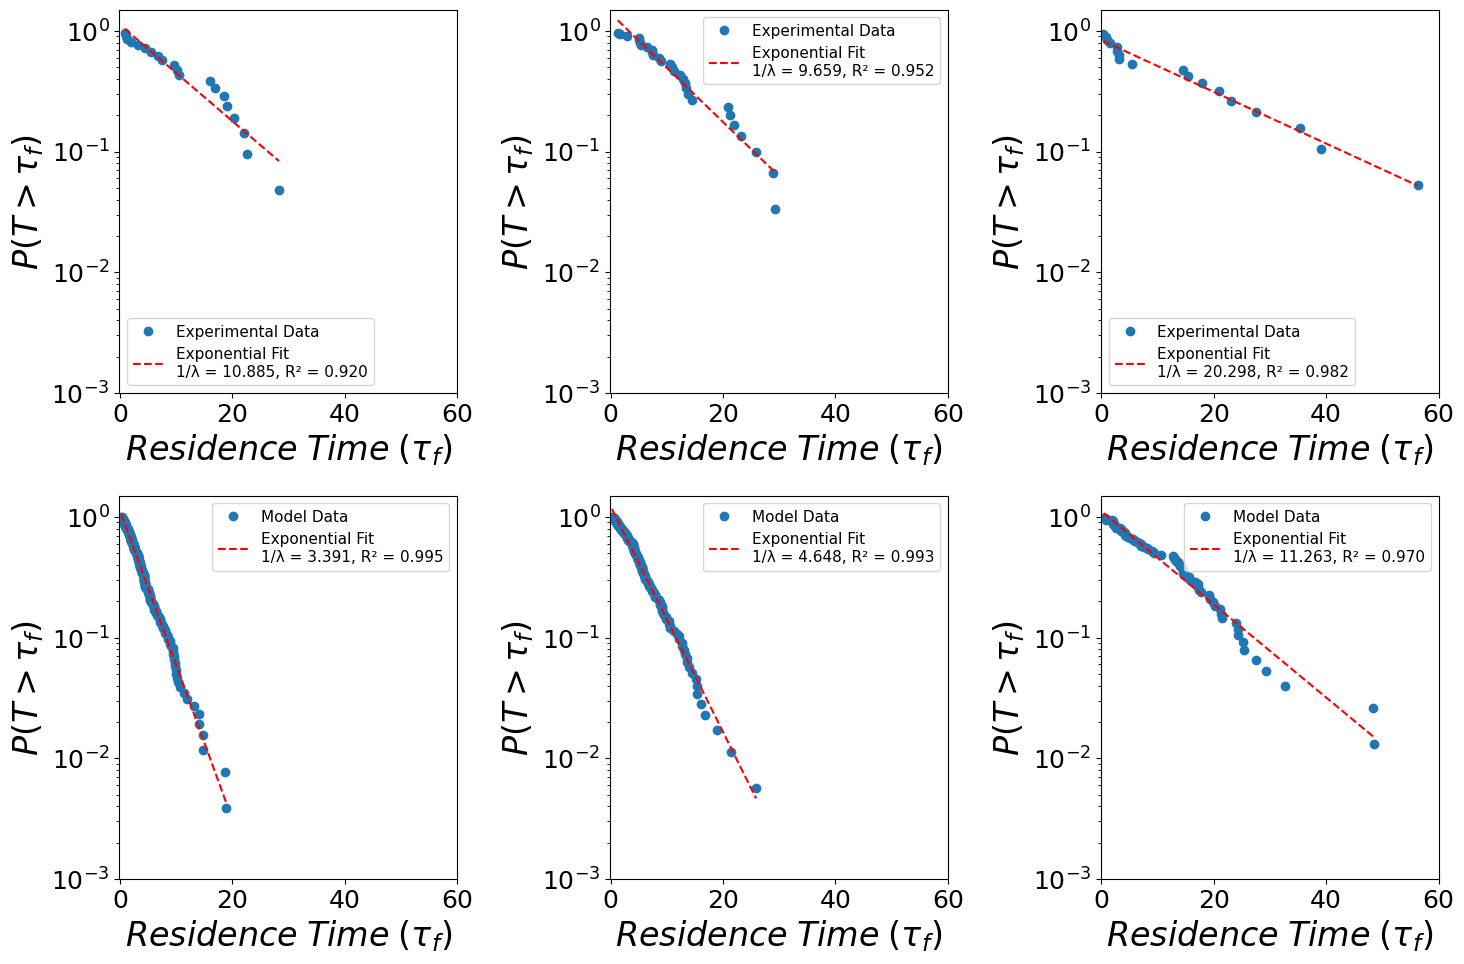

In [33]:
from scipy.stats import linregress

# Font sizes
tick_label_font_size = 18
axis_label_font_size = 24
legend_font_size = 11

plt.rc('xtick', labelsize=tick_label_font_size)
plt.rc('ytick', labelsize=tick_label_font_size)
plt.rcParams['legend.fontsize'] = legend_font_size

# Helper: compute CCDF
def compute_ccdf(data):
    data = np.array(data)
    sorted_data = np.sort(data)
    ccdf = 1.0 - np.arange(1, len(sorted_data)+1) / len(sorted_data)
    return sorted_data, ccdf

# Helper: plot exponential fit
def plot_fit(ax, xdata, ccdf_data, label='Exponential Fit'):
    mask = ccdf_data > 0
    x = xdata[mask]
    y = np.log(ccdf_data[mask])
    if len(x) < 2:
        return None, None
    slope, intercept, r_value, _, _ = linregress(x, y)
    fitted_log_ccdf = slope * x + intercept
    ax.plot(x, np.exp(fitted_log_ccdf), 'r--',
            label=f'{label}\n1/λ = {-1/slope:.3f}, R² = {r_value**2:.3f}')
    return slope, r_value**2

# Group sizes
group_sizes = ['50', '100', '200']

# Compute sorted data + CCDF
sorted_data = {}
ccdf_data = {}
model_sorted_data = {}
model_ccdf_data = {}

for g in group_sizes:
    sorted_data[g], ccdf_data[g] = compute_ccdf(
        output_dict[g]['A_to_B_durations'] + output_dict[g]['B_to_A_durations']
    )
    model_sorted_data[g], model_ccdf_data[g] = compute_ccdf(
        model_output_dict[g]['A_to_B_durations'] + model_output_dict[g]['B_to_A_durations']
    )

# Create figure
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Top row: Experimental data
for j, g in enumerate(group_sizes):
    ax[0, j].semilogy(sorted_data[g], ccdf_data[g], marker='o', linestyle='none', label='Experimental Data')
    plot_fit(ax[0, j], sorted_data[g], ccdf_data[g])
    ax[0, j].set_xlim(-0.1, 60)
    ax[0, j].set_ylim(1e-3, 1.5)
    ax[0, j].set_ylabel(r'$P(T > \tau_f)$', fontsize=axis_label_font_size)
    ax[0, j].set_xlabel(r'$Residence\;Time\;(\tau_f)$', fontsize=axis_label_font_size)
    ax[0, j].legend(loc='best')

# Bottom row: Model data
for j, g in enumerate(group_sizes):
    # If model times are in different time units, scale appropriately
    time_scale = 100 if g in ['50', '100', '200'] else 1
    ax[1, j].semilogy(model_sorted_data[g]/time_scale, model_ccdf_data[g],
                      marker='o', linestyle='none', label='Model Data')
    plot_fit(ax[1, j], model_sorted_data[g]/time_scale, model_ccdf_data[g])
    ax[1, j].set_xlim(-0.1, 60)
    ax[1, j].set_ylim(1e-3, 1.5)
    ax[1, j].set_ylabel(r'$P(T > \tau_f)$', fontsize=axis_label_font_size)
    ax[1, j].set_xlabel(r'$Residence\;Time\;(\tau_f)$', fontsize=axis_label_font_size)
    ax[1, j].legend(loc='best')

plt.tight_layout(pad=2)
plt.savefig('../figures/cdf_mean_residence_times.png', dpi=300)  # Commented as requested
plt.show()


### **Figure 7 — Cross-Correlation Between Central and Peripheral Polarization Time Series**

This figure compares the polarization dynamics of **central** and **peripheral** individuals by computing the **cross-correlation function (CCF)** between their polarization time series. The analysis is shown for three group sizes (**N = 50, 100, 200**).

For each group size, we extract:
- The polarization time series of **central individuals**
- The polarization time series of **peripheral individuals**
- The **normalized cross-correlation** across a symmetric window of time lags

**Interpretation of lag sign (important for this study):**

- **Negative lag peak:**  
  **Central individuals lead** the peripheral individuals — changes in the center occur first.

- **Positive lag peak:**  
  **Peripheral individuals lead** the central individuals.

- **Lag ≈ 0:**  
  Synchronous fluctuations in polarization between center and periphery.

**Additional interpretation:**

- **Sharp peaks** indicate strong coupling;  
- **Broad peaks** indicate slower, weaker coupling;  
- **Low amplitude curves** indicate weak or no relationship between central and peripheral dynamics.

**Panel layout:**
- **Left:** N = 50  
- **Middle:** N = 100  
- **Right:** N = 200  

Each panel shows the cross-correlation curve and highlights how the directionality and strength of coupling between center and periphery changes with group size.


In [34]:
# --- Load data ---
df_50A = pd.read_pickle('../data/df_50A_omega')
df_50B = pd.read_pickle('../data/df_50B_omega')
df_50C = pd.read_pickle('../data/df_50C_omega')
df_50D = pd.read_pickle('../data/df_50D_omega')
df_50E = pd.read_pickle('../data/df_50E_omega')

dfs_50 = [df_50A, df_50B, df_50C, df_50D, df_50E]
labels_50 = ['A', 'B', 'C', 'D', 'E']

cirOP_50 = {}
df50_cirOP = {}

# --- Process all replicates ---
for label, df in zip(labels_50, dfs_50):

    # Extract circulative OP at three concentric radii
    cent50, cent100, cent200 = dF.cirOP_concentric_rings(df)

    # Generate matched random controls
    rand50  = np.random.rand(len(cent50))  * 2 - 1
    rand200 = np.random.rand(len(cent200)) * 2 - 1

    # Store structured data
    data = np.column_stack([cent50, cent100, cent200, rand50, rand200])
    df50_cirOP[label] = pd.DataFrame(
        data,
        columns=[
            f'cirOP50{label}_cent50',
            f'cirOP50{label}_cent100',
            f'cirOP50{label}_cent200',
            f'cent50_rand_50{label}',
            f'cent200_rand_50{label}'
        ]
    )

    cirOP_50[label] = (cent50, cent100, cent200)


In [35]:
# --- Load data ---
df_100A = pd.read_pickle('../data/df_100A_omega')
df_100B = pd.read_pickle('../data/df_100B_omega')
df_100C = pd.read_pickle('../data/df_100C_omega')
df_100D = pd.read_pickle('../data/df_100D_omega')
df_100E = pd.read_pickle('../data/df_100E_omega')

dfs_100 = [df_100A, df_100B, df_100C, df_100D, df_100E]
labels_100 = ['A', 'B', 'C', 'D', 'E']

cirOP_100 = {}
df100_cirOP = {}

# --- Process all replicates ---
for label, df in zip(labels_100, dfs_100):

    cent50, cent100, cent200 = dF.cirOP_concentric_rings(df)

    rand50  = np.random.rand(len(cent50))  * 2 - 1
    rand200 = np.random.rand(len(cent200)) * 2 - 1

    data = np.column_stack([cent50, cent100, cent200, rand50, rand200])

    df100_cirOP[label] = pd.DataFrame(
        data,
        columns=[
            f'cirOP100{label}_cent50',
            f'cirOP100{label}_cent100',
            f'cirOP100{label}_cent200',
            f'cent50_rand_100{label}',
            f'cent200_rand_100{label}'
        ]
    )

    cirOP_100[label] = (cent50, cent100, cent200)


In [36]:
# --- Load data ---
df_200A = pd.read_pickle('../data/df_200A_omega')
df_200B = pd.read_pickle('../data/df_200B_omega')
df_200C = pd.read_pickle('../data/df_200C_omega')
df_200D = pd.read_pickle('../data/df_200D_omega')
df_200E = pd.read_pickle('../data/df_200E_omega')

dfs_200 = [df_200A, df_200B, df_200C, df_200D, df_200E]
labels_200 = ['A', 'B', 'C', 'D', 'E']

cirOP_200 = {}
df200_cirOP = {}

# --- Process all replicates ---
for label, df in zip(labels_200, dfs_200):

    cent50, cent100, cent200 = dF.cirOP_concentric_rings(df)

    rand50  = np.random.rand(len(cent50))  * 2 - 1
    rand200 = np.random.rand(len(cent200)) * 2 - 1

    data = np.column_stack([cent50, cent100, cent200, rand50, rand200])

    df200_cirOP[label] = pd.DataFrame(
        data,
        columns=[
            f'cirOP200{label}_cent50',
            f'cirOP200{label}_cent100',
            f'cirOP200{label}_cent200',
            f'cent50_rand_200{label}',
            f'cent200_rand_200{label}'
        ]
    )

    cirOP_200[label] = (cent50, cent100, cent200)


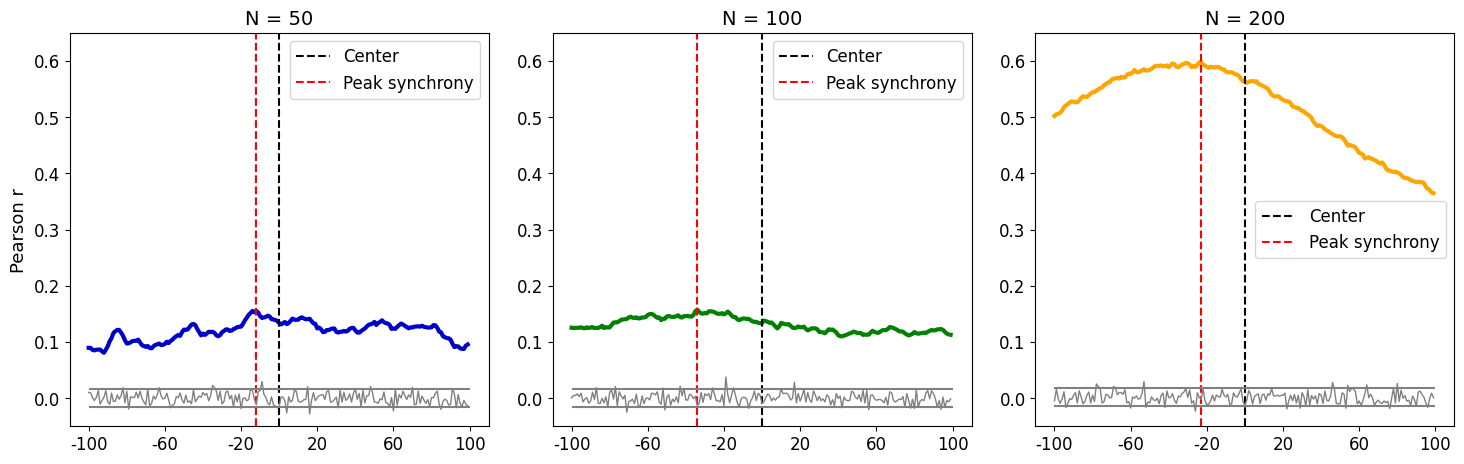

In [38]:

def plot_center_periphery(ax, df, lab_prefix, rand_suffix, color):
    """
    df must contain:
        {lab_prefix}_cent50
        {lab_prefix}_cent200
        cent50_rand_{rand_suffix}
        cent200_rand_{rand_suffix}
    """
    d1 = df[f'{lab_prefix}_cent50']
    d3 = df[f'{lab_prefix}_cent200']

    total_lag = 100
    rs = [dF.crosscorr(d1, d3, lag) for lag in range(-total_lag, total_lag)]
    peak = np.argmax(rs)

    # Main curve
    ax.plot(rs, color=color, linewidth=3)
    ax.axvline(np.ceil(len(rs)/2), color='k', linestyle='--', label='Center')
    ax.axvline(peak, color='r', linestyle='--', label='Peak synchrony')

    ax.set_ylim([-0.05, 0.65])
    ax.set_xticks([0, 40, 80, 120, 160, 200])
    ax.set_xticklabels([-100, -60, -20, 20, 60, 100], fontsize=12)
    ax.tick_params(labelsize=12)

    # Random controls
    d1r = df[f'cent50_rand_{rand_suffix}']
    d3r = df[f'cent200_rand_{rand_suffix}']
    rs_rand = [dF.crosscorr(d1r, d3r, lag) for lag in range(-total_lag, total_lag)]

    ax.plot(rs_rand, color='grey', linewidth=1)
    ax.hlines(np.percentile(rs_rand, 95), 0, 200, linewidth=1.5, color='grey')
    ax.hlines(np.percentile(rs_rand, 5), 0, 200, linewidth=1.5, color='grey')


# --------------------------
# Final plotting
# --------------------------
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.02, wspace=0.15)

# --- Panel 1: N = 50D ---
plot_center_periphery(
    ax[0],
    df50_cirOP['D'],
    lab_prefix='cirOP50D',
    rand_suffix='50D',
    color='mediumblue'
)
ax[0].set_title("N = 50", fontsize=14)
ax[0].set_ylabel("Pearson r", fontsize=13)

# --- Panel 2: N = 100D ---
plot_center_periphery(
    ax[1],
    df100_cirOP['D'],
    lab_prefix='cirOP100D',
    rand_suffix='100D',
    color='g'
)
ax[1].set_title("N = 100", fontsize=14)

# --- Panel 3: N = 200E ---
plot_center_periphery(
    ax[2],
    df200_cirOP['E'],
    lab_prefix='cirOP200E',
    rand_suffix='200E',
    color='orange'
)
ax[2].set_title("N = 200", fontsize=14)

# Legends
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
ax[2].legend(fontsize=12)

plt.tight_layout(pad=2)
plt.savefig('../figures/cross_corr_all_group_size.png',dpi=600,transparent=False)
plt.show()


### Figure 8: Distribution of Angular Polarization from model under Different Boundary Size

This figure shows the **relative frequency distributions of the angular polarization** \(M\) of the system for different boundary sizes (\(L = 50, 75, 100\)), as obtained from the simulation time series.

- **Panels:**  
  - **Left panel:** Histogram of \(M\) for two representative time series per boundary condition (datasets 0 and 2) for the first half of the population.  
  - **Right panel:** Same as left panel for another set of time series (datasets 0 and 2) for the second half of the population.  

- **Colors:**  
  - Blue: \(L = 50\)  
  - Green: \(L = 75\)  
  - Red: \(L = 100\)  

- **Histogram details:**  
  - Bins: \([-1, 1]\) with step size 0.02  
  - Normalized to **relative frequency** \(P(M)\)  
  - Line type: Step histogram  
  - Alpha: 0.7 for clarity  

- **Interpretation:**  
  - Peaks near \(M \approx 1\) or \(M \approx -1\) indicate **strong collective alignment**.  
  - Width and spread of distributions show **fluctuations in polarization** due to boundary effects.  

- **Axis labels:**  
  - \(x\)-axis: Angular Polarization \((M)\)  
  - \(y\)-axis: Relative Frequency \([P(M)]\)  

- **Legend:** Colored lines correspond to different boundary conditions as indicated.


In [39]:

# --- Load simulation videos for N = 50, 100, 200 (circular arena) ---

video_paths = {
    "N50":  "../movies/simulation_N50L50_circular.mp4",
    "N100": "../movies/simulation_N100L50_circular.mp4",
    "N200": "../movies/simulation_N200L50_circular.mp4",
}

# Create readers in a clean dictionary
vid_sims = {}

for key, path in video_paths.items():
    try:
        vid_sims[key] = imageio.get_reader(path, 'ffmpeg')
        print(f"Loaded video: {key}  ({path})")
    except FileNotFoundError:
        print(f"❌ File not found: {path}")
    except Exception as e:
        print(f"⚠️ Could not load {key} due to error:\n{e}")

# Access examples:
# vid_sims["N50"]
# vid_sims["N100"]
# vid_sims["N200"]


Loaded video: N50  (../movies/simulation_N50L50_circular.mp4)
Loaded video: N100  (../movies/simulation_N100L50_circular.mp4)
Loaded video: N200  (../movies/simulation_N200L50_circular.mp4)


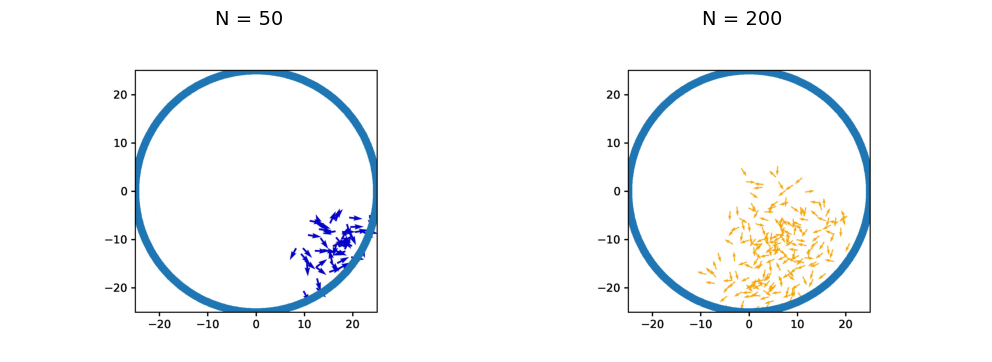

In [40]:
# ============================================================
# Figure: Boundary interactions in circular arena
# Comparison of N = 50 and N = 200 simulations
# ============================================================

f, ax = plt.subplots(1, 2, figsize=(10, 5))
f.set_facecolor('white')

# -----------------------------------------
# Left panel: N = 50 snapshot
# -----------------------------------------
frame_50 = 490
img_50 = vid_sims["N50"].get_data(frame_50)

ax[0].imshow(img_50)
ax[0].set_title("N = 50", fontsize=14)
ax[0].axis('off')

# -----------------------------------------
# Right panel: N = 200 snapshot
# -----------------------------------------
frame_200 = 300
img_200 = vid_sims["N200"].get_data(frame_200)

ax[1].imshow(img_200)
ax[1].set_title("N = 200", fontsize=14)
ax[1].axis('off')

# -----------------------------------------
plt.tight_layout(pad=1)
plt.savefig("../figures/boundary_arena_si.png", dpi=300)
plt.show()


In [43]:

L = ['25', '50', '75', '100']
model_angular_pol = []

basepath = "../data/model_data/"

for suffix in L:
    filepath = basepath + f"angular_pol_timeSeries_N_50_100_200_boundary{suffix}"
    with open(filepath, 'rb') as f:
        model_angular_pol.append(pickle.load(f))


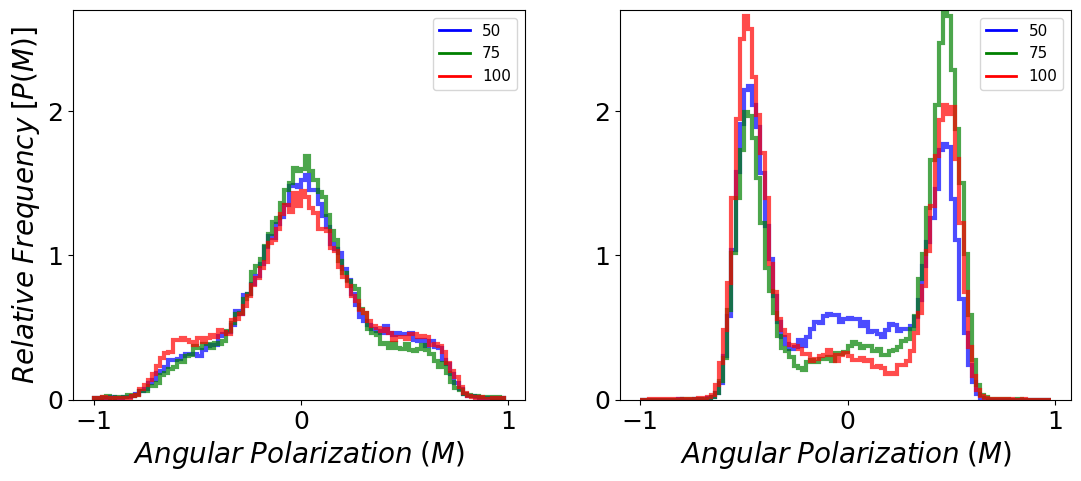

In [44]:
from matplotlib.lines import Line2D

# ---- Settings ----
L = ['25', '50', '75', '100']  # Boundary conditions
c = ['orange', 'blue', 'green', 'red']  # Colors for each boundary
tick_label_font_size = 18
axis_label_font_size = 20

# ---- Create figure ----
f, ax = plt.subplots(1, 2, figsize=(12, 6))

# ---- Plot histograms ----
handles = []

for i in range(1, len(L)):  # Skip L[0] if desired
    for j, k in enumerate([0, 2]):  # Use 0th and 2nd datasets per boundary
        ax[j].hist(
            model_angular_pol[i][k],
            bins=np.arange(-1, 1, 0.02),
            histtype='step',
            linewidth=3,
            density=True,
            color=c[i],
            alpha=0.7
        )
        ax[j].set_ylim([0, 2.7])
        ax[j].set_yticks(np.arange(0, 3, 1))
        ax[j].set_xticks(np.arange(-1, 1.1, 1))
    
    # Add custom Line2D for legend
    handles.append(Line2D([0], [0], color=c[i], lw=2))

# ---- Add legends ----
labels = L[1:]  # ['50','75','100']
ax[0].legend(handles, labels)
ax[1].legend(handles, labels)

# ---- Axis labels ----
ax[0].set_ylabel(r'$Relative\;Frequency\;[P(M)]$', fontsize=axis_label_font_size)
ax[0].set_xlabel(r'$Angular\;Polarization\;(M)$', fontsize=axis_label_font_size)
ax[1].set_xlabel(r'$Angular\;Polarization\;(M)$', fontsize=axis_label_font_size)

# ---- Final layout ----
plt.tight_layout(pad=5)
plt.savefig('../figures/boundary_model_analysis_si.png', dpi=300)  # Save if needed
plt.show()
